In [73]:
!pip install pyspark
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder , StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
import os
from pyspark.sql.functions import col, sum as _sum
import os
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.functions import col, rand
from pyspark.sql import functions as F
import seaborn as sns
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

+-----+----------+----------+--------+---------+-------------+-------------+----------------+--------------+--------+-----------+---------+------------+-----------+
|Order| File_Type|SKU_number|SoldFlag|SoldCount|MarketingType|ReleaseNumber|New_Release_Flag|StrengthFactor|PriceReg|ReleaseYear|ItemCount|LowUserPrice|LowNetPrice|
+-----+----------+----------+--------+---------+-------------+-------------+----------------+--------------+--------+-----------+---------+------------+-----------+
|    2|Historical|   1737127|       0|        0|            D|           15|               1|      682743.0|   44.99|       2015|        8|       28.97|      31.84|
|    3|Historical|   3255963|       0|        0|            D|            7|               1|     1016014.0|   24.81|       2005|       39|         0.0|      15.54|
|    4|Historical|    612701|       0|        0|            D|            0|               0|      340464.0|    46.0|       2013|       34|       30.19|      27.97|
|    6|His

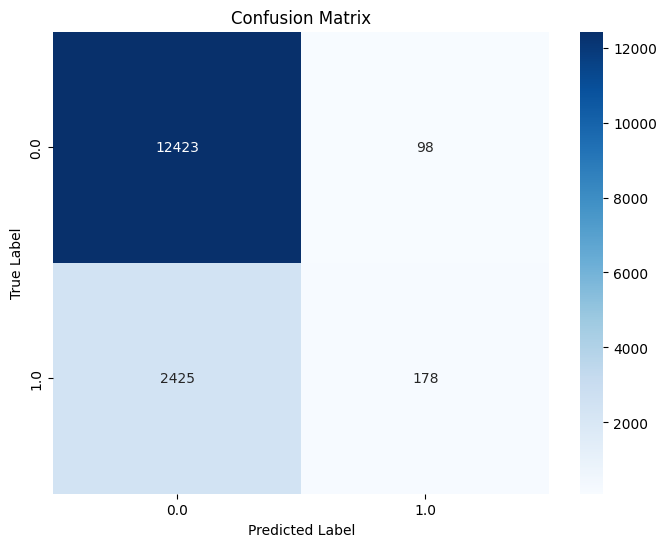

In [76]:
def pre(df):
    df = df.filter(col('File_Type') == 'Historical')
    df = df.drop('Order', 'File_Type', 'SKU_number', 'SoldCount')
    df = df.withColumn("random", rand()).orderBy("random").drop("random")
    return df

def build_pip():
    indexer = StringIndexer(inputCol='MarketingType', outputCol='MarketingTypeIndex')
    encoder = OneHotEncoder(inputCol='MarketingTypeIndex', outputCol='MarketingTypeVec')
    assembler = VectorAssembler(
        inputCols=['MarketingTypeVec', 'ReleaseNumber', 'New_Release_Flag', 'StrengthFactor',
                   'PriceReg', 'ReleaseYear', 'ItemCount', 'LowUserPrice', 'LowNetPrice'],
        outputCol='features'
    )
    classifier = RandomForestClassifier(labelCol='SoldFlag', featuresCol='features', seed=1)
    pipeline = Pipeline(stages=[indexer, encoder, assembler, classifier])
    return pipeline

spark = SparkSession.builder \
    .appName("SalesDataPipeline") \
    .getOrCreate()

file_path = "/content/SalesKaggle3.csv"
file_size = os.path.getsize(file_path)
df_csv = spark.read.csv(file_path, header=True, inferSchema=True)
df_csv.show()
print(f"File Size: {file_size} bytes")

df_preprocessed = pre(df_csv)
df_preprocessed.printSchema()
df_preprocessed = df_preprocessed.withColumn("SoldFlag", df_preprocessed["SoldFlag"].cast("double"))
df_preprocessed.printSchema()
df_preprocessed = df_preprocessed.dropna(subset=["SoldFlag"])
df_preprocessed.show()

pipeline = build_pip()
train_data, test_data = df_preprocessed.randomSplit([0.8, 0.2], seed=1)
model = pipeline.fit(train_data)
predictions = model.transform(test_data)
predictions.select('MarketingType', 'SoldFlag', 'prediction').show()

true_labels = predictions.select("SoldFlag").rdd.flatMap(lambda x: x)
predicted_labels = predictions.select("prediction").rdd.flatMap(lambda x: x)
confusion_matrix = predictions.groupBy("SoldFlag", "prediction").count().orderBy("SoldFlag", "prediction")
confusion_matrix.show()


evaluator = MulticlassClassificationEvaluator(labelCol="SoldFlag", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

confusion_matrix_pd = confusion_matrix.toPandas()
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_pd.pivot(index='SoldFlag', columns='prediction', values='count'), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

spark.stop()
